In [35]:
#Load relevant pacakages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
import os, sys, glob, yaml, datetime, argparse
import csv
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
#Grab some relevant part of util.py in qtrkx-gnn-tracking
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])
class GraphDataset():
    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = (
            filenames[:n_samples] if n_samples is not None else filenames)

    def __getitem__(self, index):
        return load_graph(self.filenames[index])

    def __len__(self):
        return len(self.filenames)
def get_dataset(input_dir,n_files):
    return GraphDataset(input_dir, n_files)
def load_graph(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Reade a single graph NPZ"""
    with np.load(full_path) as f:
        return sparse_to_graph(**dict(f.items()))
def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)

In [ ]:
#Coloring functions
def graph_coloring(graph_name):
    graph_ex=load_graph(graph_name)
    #Load raw data
    X = graph_ex.X
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    y=graph_ex.y
    #Need to change type for later use.
    y=y.astype(np.int32)
    Ri = Ri.astype(np.int32)
    Ro = Ro.astype(np.int32)
    # Get the number of nodes and edges
    NV, NE = Ri.shape
    # Initialize the coloring vector
    coloring = np.zeros(NV, dtype=int)
    # Create a dictionary to store the neighbors of each node
    neighbors = {i: [] for i in range(NV)}
    print("Start getting neighborhood information")
    for k in range(NE):
        if k%2000==0: 
            print("Performing ",k,"-th iteration...")
        if y[k] == 1:
            for j in range(NV):
                if Ro[j, k] == 1:
                    for i in range(NV):
                        if Ri[i, k] == 1 and i != j:
                            neighbors[j].append(i)
    print("Start greedy coloring.")
    # Greedy coloring
    for node in range(NV):
        used_colors = set(coloring[n] for n in neighbors[node])
        # Find the smallest unused color
        color = 0
        while color in used_colors:
            color += 1
        coloring[node] = color
    return X, y, Ri, Ro, coloring
#Include coloring to the original X data frame
def color_df(original_X,color):
    X_color = pd.DataFrame(original_X,columns=['x','y','z'])
    X_color['color'] = color
    return X_color
#If there are too many data points, reduce.
def color_df_red(original_X,color):
    X_color=color_df(original_X,color)
    X_color['r'] = np.sqrt(X_color['x']**2 + X_color['y']**2)
    X_color_red=X_color[(X_color['z']<0.1)&(X_color['z']>-0.1)
                   &(X_color['y']>0)&(X_color['r']<0.2)]
    return X_color_red

In [ ]:
#Plotting functions
def plot3d(df,st):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    # Replace 'x', 'y', 'z', and 'label' with the actual column names in your DataFrame
    x = df['x']
    y = df['y']
    z = df['z']
    label = df[st]
    scatter = ax.scatter(x, y, z, c=label, cmap='viridis', s=25)
    # Add a colorbar to show the mapping of labels to colors
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('Label')
    # Set labels for the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    # Show the plot
    plt.show()
def plot2d(df,st):
    # Replace 'x', 'y', and 'label' with the actual column names in your DataFrame
    x = df['x']
    y = df['y']
    labels = df[st]
    # Create a scatter plot with colors based on the 'label' column
    plt.scatter(x, y, c=labels, cmap='viridis', s=25)
    # Add a colorbar to show the mapping of labels to colors
    colorbar = plt.colorbar()
    colorbar.set_label('Label')
    # Set labels for the axes
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    # Show the plot
    plt.show()

In [ ]:
#Matrix multiplication to prepare input for HNN
def doublet(Ri,Ro,v):
    v = v.values #convert colored data frame to numpy array
    # Ri = (NV,NE), v = (NV,3+1)
    bo = np.matmul(Ri.T,v) 
    bi = np.matmul(Ro.T,v)
    return bo,bi
def triplet(Ri,Ro,v,e):
    v = v.values #convert colored data frame to numpy array
    # Ri,Ro = (NV, NE), v = (NV,3+1), e = (NE,)
    # Perform the operation using Einstein summation notation
    vi = np.einsum('jk,k,k->j', Ri, e, v)
    vo = np.einsum('jk,k,k->j', Ro, e, v)
    return vi,vo,v

In [ ]:
#Data management functions
def save_color_df(graph_name,folder):
    X, _, _, _, coloring = graph_coloring(graph_name)
    X_color = color_df(X,coloring)
    X_color_red = color_df_red(X,coloring)
    dir_ = os.path.join(os.getcwd(), folder)
    # Ensure that the 'dir_' directory exists; if not, create it
    if not os.path.exists(dir_):
        os.makedirs(dir_)
    # Specify the full file path, including the directory and filename
    graph_name_=graph_name[:-4]
    graph_name_red = graph_name_+'_red'
    file_path = os.path.join(dir_, f"{graph_name_}.csv")
    file_path_red = os.path.join(dir_, f"{graph_name_red}.csv")
    # Save the DataFrame as a CSV file
    X_color.to_csv(file_path, index=False)
    X_color_red.to_csv(file_path_red, index=False)
def file_names(folder):
    # Specify the directory path 
    graph_dir = os.path.join(os.getcwd(), folder)
    # Get a list of all files in the directory
    file_names = os.listdir(graph_dir)
    # filter out only files
    file_names = [f for f in file_names if os.path.isfile(os.path.join(graph_dir, f))]
    return file_names

In [19]:
X, y, Ri, Ro, coloring = graph_coloring('event000001010_g000.npz')
print(coloring)

Start getting neighborhood information
Performing  0 -th iteration...
Performing  2000 -th iteration...
Performing  4000 -th iteration...
Performing  6000 -th iteration...
Start greedy coloring.
[1 1 1 ... 1 1 0]


In [20]:
print("Coloring vector sum: ",coloring.sum(), ", y vector sum: ",y.sum())

Coloring vector sum:  3803 , y vector sum:  3803


In [21]:
X_color = color_df(X,coloring)
X_color_red = color_df_red(X,coloring)
print("Color included data frame: ",X_color.shape,
      "\n After reduction: ",X_color_red.shape)

Color included data frame:  (4739, 4) 
 After reduction:  (112, 5)


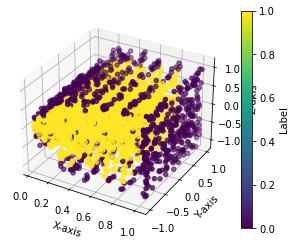

In [106]:
#Full 3d graphic for event000001000_g000.npz: 
plot3d(X_color,'color')

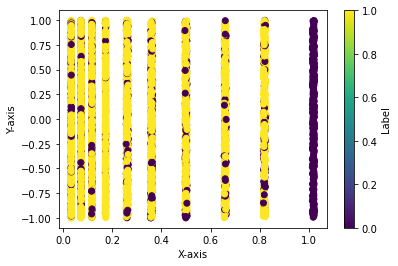

In [107]:
#Full 2d graphic for event000001000_g000.npz
plot2d(X_color,'color')

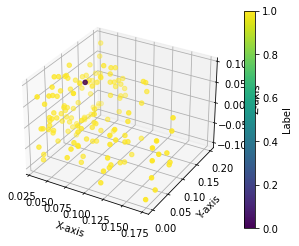

In [108]:
#Reduced 3d graphic for event000001000_g000.npz
plot3d(X_color_red,'color')

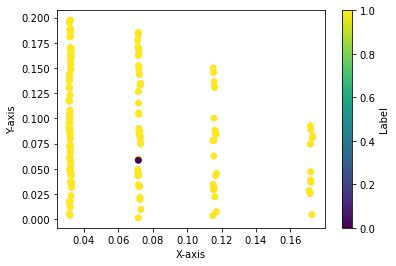

In [109]:
#Reduced 2d graphic for event000001000_g000.npz
plot2d(X_color_red,'color')

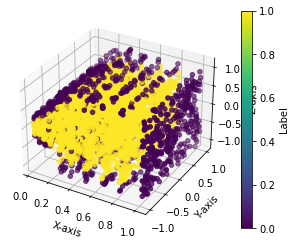

In [15]:
#Full 3d graphic for event000001006_g000.npz: 
plot3d(X_color,'color')

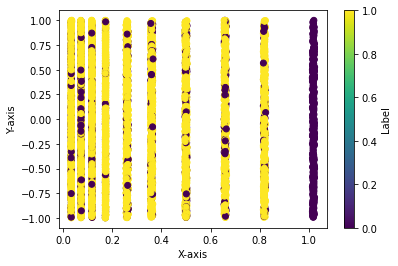

In [16]:
#Full 2d graphic for event000001006_g000.npz
plot2d(X_color,'color')

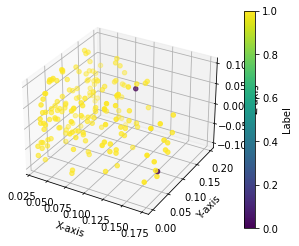

In [17]:
#Reduced 3d graphic for event000001006_g000.npz
plot3d(X_color_red,'color')

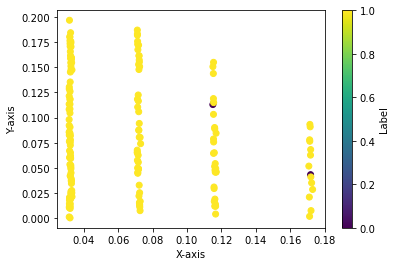

In [18]:
#Reduced 2d graphic for event000001006_g000.npz
plot2d(X_color_red,'color')

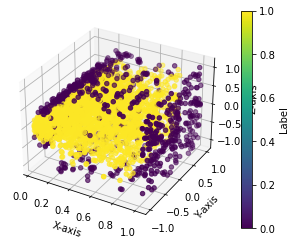

In [22]:
#Full 3d graphic for event000001006_g000.npz: 
plot3d(X_color,'color')

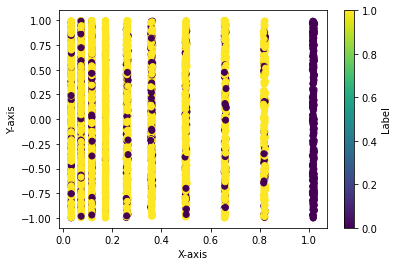

In [23]:
#Full 2d graphic for event000001006_g000.npz: 
plot2d(X_color,'color')

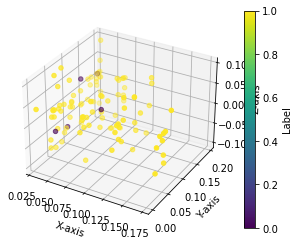

In [24]:
#Reduced 3d graphic for event000001006_g000.npz
plot3d(X_color_red,'color')

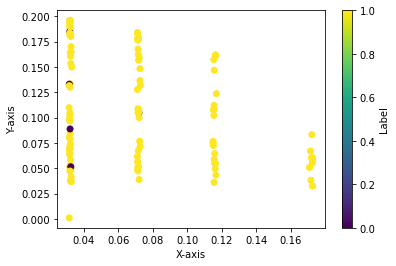

In [25]:
#Reduced 2d graphic for event000001006_g000.npz
plot2d(X_color_red,'color')

In [ ]:
#Creating colored data set for 10 graphs.
graph_names = file_names("graphs")
for graph_name in graph_names:
    save_color_df(graph_name,'data')

Start getting neighborhood information
Performing  0 -th iteration...
Performing  2000 -th iteration...
Performing  4000 -th iteration...
Performing  6000 -th iteration...
Performing  8000 -th iteration...
Start greedy coloring.
Start getting neighborhood information
Performing  0 -th iteration...
Performing  2000 -th iteration...
Performing  4000 -th iteration...
Performing  6000 -th iteration...
